## Library import

In [1]:
!nvidia-smi

Sat Mar 12 08:40:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    57W / 300W |  19642MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0    95W / 300W |  16998MiB / 32480MiB |     32%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import torch

torch.cuda.set_device(3)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:3"
torch.cuda.current_device()

3

In [8]:
# !pip install keras -q
# !pip install tensorflow -q

In [9]:
import pandas as pd 
import numpy as np
import time 
import matplotlib.pyplot as plt


import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# preliminaries 
import torchtext
from torchtext.legacy.data import Field, LabelField, TabularDataset, BucketIterator
# models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
# training
import torch.optim as optim
# reproducible
SEED = 42
#Torch
torch.manual_seed(SEED)
#algoritma cuda
torch.backends.cudnn.deterministic = True 

## Prepare dataset

In [12]:
userPath = 'revision_dataset/'
tweetPath = 'revision_dataset/tweetAgg/'

In [13]:
userlvltrain = pd.read_csv(userPath+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPath+'/userlvltest.csv')
userlvlval = pd.read_csv(userPath+'/userlvlval.csv')

tweets_xtrain_df = pd.read_csv(tweetPath+'aggtrain_df.csv')
tweets_xtrain_df['label'] = userlvltrain.Lvalue
tweets_xtest_df = pd.read_csv(tweetPath+'aggtest_df.csv')
tweets_xtest_df['label'] = userlvltest.Lvalue
tweets_xval_df = pd.read_csv(tweetPath+'aggval_df.csv')
tweets_xval_df['label'] = userlvltest.Lvalue

In [18]:
tokenizer = Tokenizer(oov_token=True)
tokenizer.fit_on_texts(tweets_xtrain_df.text)
word_index = tokenizer.word_index

# The maximum number of words to be used. 
vocab_size = len(word_index) + 1 
# Max number of words in each tweets.  
maxlen = int(tweets_xtrain_df.text.str.len().max()) 
# This is fixed.
embedding_size = 512
batch_size = 64

print(vocab_size, "vocab size")
print(maxlen, "max len")
print(embedding_size, "embedding dim")
print(batch_size, "batch size")

94654 vocab size
19639 max len
512 embedding dim
64 batch size


In [19]:
Y_train = tweets_xtrain_df.label
Y_test = tweets_xtest_df.label
Y_valid = tweets_xval_df.label

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(userlvltrain.userLocation)
label_names = le.classes_
label_names

array(['bali dan nusa tenggara', 'jabodetabek', 'jawa barat dan banten',
       'jawa tengah dan yogyakarta', 'jawa timur', 'kalimantan',
       'maluku dan papua', 'sulawesi', 'sumatera'], dtype=object)

In [21]:
# tokenizer and padding
X_train = tokenizer.texts_to_sequences(tweets_xtrain_df.text.values)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(tweets_xtest_df.text.values) 
X_test = pad_sequences(X_test, maxlen=maxlen)
X_valid = tokenizer.texts_to_sequences(tweets_xval_df.text.values) 
X_valid = pad_sequences(X_valid, maxlen=maxlen)

# Load train and test in CUDA Memory
x_train = torch.tensor(X_train, dtype=torch.long).cuda()
y_train = torch.tensor(Y_train, dtype=torch.long).cuda()
x_test = torch.tensor(X_test, dtype=torch.long).cuda() 
y_test = torch.tensor(Y_test, dtype=torch.long).cuda()
x_valid = torch.tensor(X_valid, dtype=torch.long).cuda()
y_valid = torch.tensor(Y_valid, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)
valid = torch.utils.data.TensorDataset(x_valid, y_valid)


# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

## LSTM 

In [22]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 1
        drp = 0.5
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(1, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

### LSTM training and Evaluation

In [23]:
n_epochs = 30
n_epochs_stop = 3 
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf


lstm = BiLSTM()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, lstm.parameters()), lr=5e-3)
lstm.cuda()

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    lstm.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = lstm(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

        if avg_loss < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = avg_loss
        else:
          epochs_no_improve += 1 
        
        if epoch>3 and epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue
        break
    if early_stop:
      break
  
    # Set model to validation configuration -Doesn't get trained here
    lstm.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_valid),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = lstm(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred, dim = 1).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==Y_valid)/len(Y_valid)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

Epoch 1/30 	 loss=2.3615 	 val_loss=2.2492  	 val_acc=0.1700  	 time=13.38s
Epoch 2/30 	 loss=2.2675 	 val_loss=2.2320  	 val_acc=0.1700  	 time=11.27s
Epoch 3/30 	 loss=2.2431 	 val_loss=2.2219  	 val_acc=0.1700  	 time=11.56s
Epoch 4/30 	 loss=2.2221 	 val_loss=2.2140  	 val_acc=0.1700  	 time=11.40s
Early stopping!


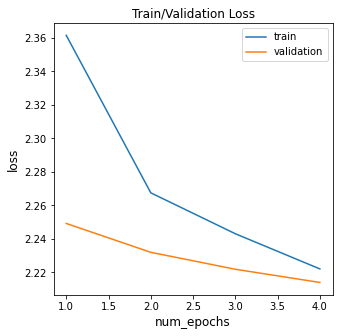

In [24]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(5,5))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(epoch)

In [25]:
torch.save(lstm.state_dict(), 'lstm_agg.pt')

In [26]:
saved_model = BiLSTM()
saved_model.load_state_dict(torch.load('lstm_agg.pt'))
saved_model.eval()
saved_model.cuda()

BiLSTM(
  (embedding): Embedding(94654, 512)
  (lstm): LSTM(512, 1, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=1, out_features=9, bias=True)
)

In [27]:
#  Fungsi evaluasi
def predict(model, test_loader):
    model.eval()
    with torch.no_grad():
      test_preds = np.zeros((len(x_test),len(le.classes_)))
      for i, (x_batch, y_batch) in enumerate(test_loader):
        y_pred = model(x_batch).detach()
        # keep/store predictions
        test_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred, dim = 1).cpu().numpy()
      test_preds = test_preds.argmax(axis=1)
      return test_preds

ypred = predict(saved_model, test_loader) 

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


print('accuracy %s' % round(accuracy_score(Y_test, ypred),2 ))
print(classification_report(Y_test, ypred,target_names=label_names))

accuracy 0.14
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.00      0.00      0.00        26
               jabodetabek       0.00      0.00      0.00        28
     jawa barat dan banten       0.00      0.00      0.00        32
jawa tengah dan yogyakarta       0.14      1.00      0.25        36
                jawa timur       0.00      0.00      0.00        34
                kalimantan       0.00      0.00      0.00        22
          maluku dan papua       0.00      0.00      0.00        23
                  sulawesi       0.00      0.00      0.00        20
                  sumatera       0.00      0.00      0.00        29

                  accuracy                           0.14       250
                 macro avg       0.02      0.11      0.03       250
              weighted avg       0.02      0.14      0.04       250



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
